⚠️ 未找到影像，為你下載官方 facades 資料集...
30168306/30168306 ━━━━━━━━━━━━━━━━━━━━ 31s 1us/step


/tmp/ipython-input-3310591388.py:33: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path='/content')


✅ 下載並解壓完成。
📦 影像數量：train=400, test=106


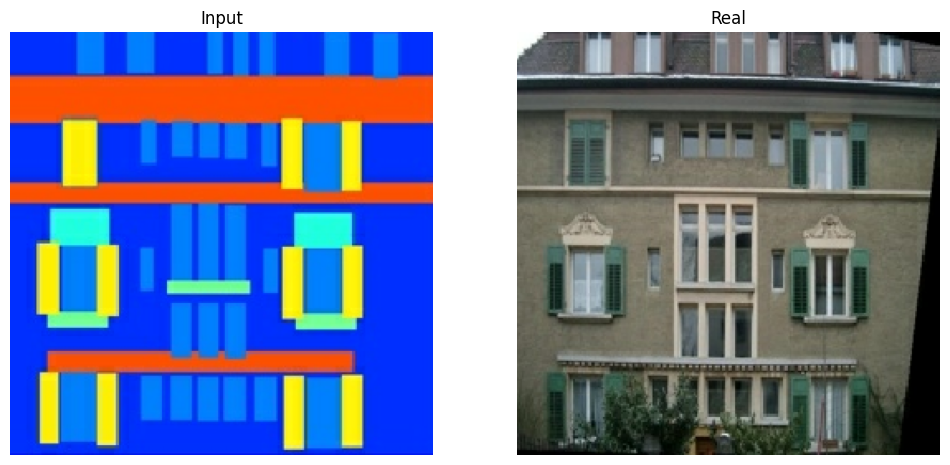

In [ ]:
# -*- coding: utf-8 -*-
import os, tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import urllib.request

# === 1) 基本設定 ===
PATH = '/content/facades/'
TRAIN_DIR = os.path.join(PATH, 'train')
TEST_DIR  = os.path.join(PATH, 'test')

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR,  exist_ok=True)

# === 2) 若無影像，自動下載 facades 資料集並解壓 ===
def ensure_facades_dataset():
    def has_images(d):
        return bool(tf.io.gfile.glob(os.path.join(d, '*.jpg')) +
                    tf.io.gfile.glob(os.path.join(d, '*.png')))
    if has_images(TRAIN_DIR) and has_images(TEST_DIR):
        print("✅ 偵測到現有影像，略過下載。")
        return

    print("⚠️ 未找到影像，為你下載官方 facades 資料集...")
    # Updated URL to a known working mirror
    url = 'https://people.eecs.berkeley.edu/~pix2pix/datasets/facades.tar.gz'
    tgz_path = tf.keras.utils.get_file(
        'facades.tar.gz', origin=url, extract=False,
        cache_dir='/content', cache_subdir=''
    )
    # 解壓
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path='/content')
    # 下載後資料夾就是 /content/facades，裡面含 train/test/val
    assert os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR), "資料解壓結構異常，請重試。"
    print("✅ 下載並解壓完成。")

ensure_facades_dataset()

# === 3) 檔案蒐集（支援 jpg + png） ===
def get_files(dirpath):
    jpgs = tf.io.gfile.glob(os.path.join(dirpath, '*.jpg'))
    pngs = tf.io.gfile.glob(os.path.join(dirpath, '*.png'))
    files = sorted(jpgs + pngs)
    if not files:
        raise FileNotFoundError(f'在 {dirpath} 找不到 .jpg 或 .png，請確認路徑/網路/前一步是否成功。')
    return files

train_files = get_files(TRAIN_DIR)
test_files  = get_files(TEST_DIR)
print(f"📦 影像數量：train={len(train_files)}, test={len(test_files)}")

# === 4) 讀圖＆前處理（保留你的增強邏輯，但支援 jpg/png） ===
def load_image(image_file):
    img = tf.io.read_file(image_file)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])

    w = tf.shape(img)[1] // 2
    real_image  = tf.cast(img[:, :w, :], tf.float32)   # 左半：target
    input_image = tf.cast(img[:, w:, :], tf.float32)   # 右半：input
    return input_image, real_image

def resize(input_image, real_image, h, w):
    input_image = tf.image.resize(input_image, [h, w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image  = tf.image.resize(real_image,  [h, w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def normalize(input_image, real_image):
    return (input_image / 127.5) - 1.0, (real_image / 127.5) - 1.0

@tf.function
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    stacked = tf.stack([input_image, real_image], axis=0)
    cropped = tf.image.random_crop(stacked, size=[2, 256, 256, 3])
    input_image, real_image = cropped[0], cropped[1]
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image  = tf.image.flip_left_right(real_image)
    return input_image, real_image

def load_train_image(path):
    x, y = load_image(path)
    x, y = random_jitter(x, y)
    x, y = normalize(x, y)
    return x, y

def load_test_image(path):
    x, y = load_image(path)
    x, y = resize(x, y, 256, 256)
    x, y = normalize(x, y)
    return x, y

# === 5) 建立 Dataset ===
BUFFER_SIZE = 400
BATCH_SIZE  = 1

train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === 6) 快速目視確認 ===
for inp, real in train_dataset.take(1):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1); plt.title('Input'); plt.imshow((inp[0]*0.5+0.5).numpy().clip(0,1)); plt.axis('off')
    plt.subplot(1,2,2); plt.title('Real');  plt.imshow((real[0]*0.5+0.5).numpy().clip(0,1)); plt.axis('off')
    plt.show()